# Preprocessing pipeline for Data

## 1. Read .mat file into numpy arrays

The data has the shape [64, 1500, 40, 6] (64 electrodes, 1500 data points and 40 trails in 60 blocks -> meaning 240 trials in total per subject)

In [ ]:
#Packages
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import numpy as np
import mne
from mne_icalabel import label_components



In [ ]:
# Load the .mat file for one subject

location="/Users/ankadilfer/Desktop/Master DTU/Semester 2/Introduction to Brain Computer Interfaces/Project Code/MI_Pipeline/MI_BCI_Data/PATID16.mat"
data = loadmat(location, squeeze_me=True, struct_as_record=False)
s = data["subjectData"]   # or whatever the variable is called

subject_id = str(np.squeeze(s.subjectId))
fs = int(np.squeeze(s.fs))
init_delay = int(np.squeeze(s.INIT_DELAY))
mi_duration = int(np.squeeze(s.MI_DURATION))#
trials = s.trialsData
label = s.trialsLabels


# trials: length 434, each (1536, 16)
X = np.stack([t.T for t in trials], axis=0)   # (trials, channels, samples)
trials_num, channels, samples = X.shape
y = np.squeeze(label).astype(int)



## 2.Reshape data and create mne epoche object

In [32]:
# Reshape data 
# trials: length 434, each (1536, 16)
X = np.stack([t.T for t in trials], axis=0)   # (trials, channels, samples)
trials_num, channels, samples = X.shape
y = np.squeeze(label).astype(int)

events = np.zeros((len(y), 3), dtype=int)
events[:, 0] = np.arange(len(y))       # arbitrary sample index
events[:, 2] = y                       # class labels

event_id = {
    "left_hand": 0,
    "right_hand": 1
}


channels = [
    "F3", "Fz", "F4",
    "FC3", "FC1", "FC2", "FC4",
    "C3", "Cz", "C4",
    "CP3", "CP1", "CP2", "CP4",
    "P3", "P4"
]


info = mne.create_info(
    ch_names=channels,   
    sfreq=fs,               
    ch_types="eeg"
)


epochs = mne.EpochsArray(
    X,
    info,
    events=events,
    event_id=event_id,
    tmin=0
)


print(y.shape)

Not setting metadata
434 matching events found
No baseline correction applied
0 projection items activated
(434,)


## 4. Set MNE montage

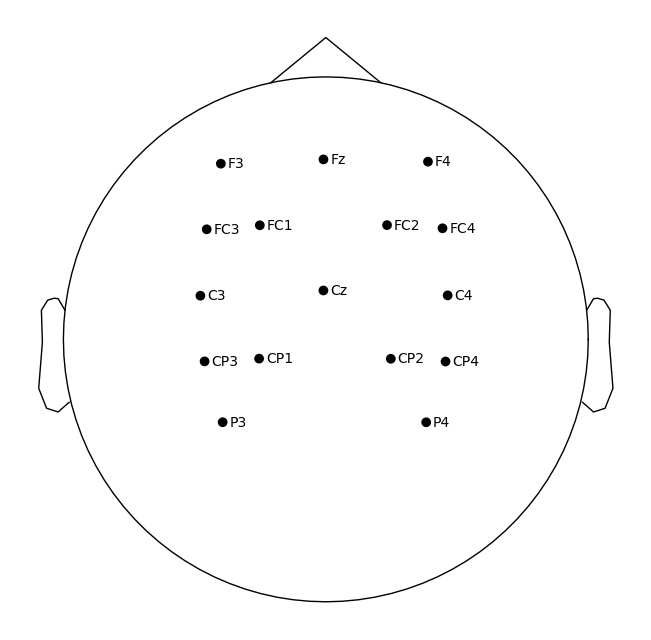

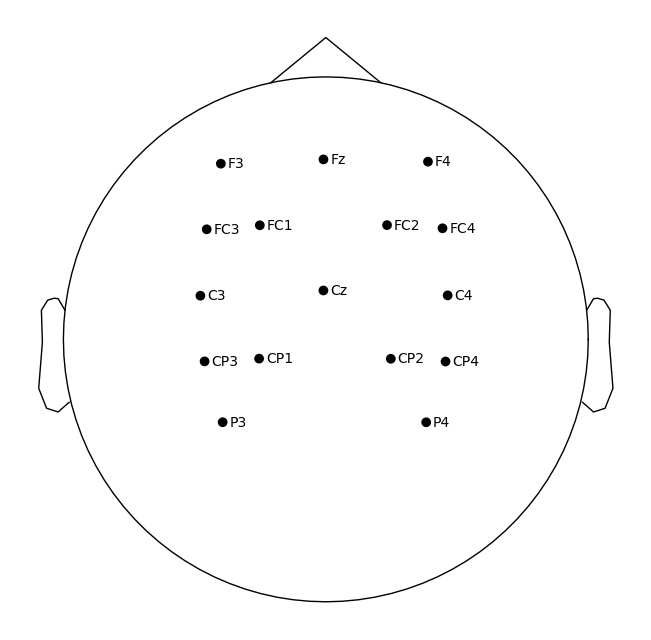

In [25]:

montage = mne.channels.make_standard_montage('standard_1020')


epochs.set_montage(montage, match_case=False)

epochs.plot_sensors(show_names=True)


# 5. Bandpass filtering

Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 1 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 70.00 Hz: -6.02, -6.02 dB

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/Users/ankadilfer/anaconda3/envs/new_env_name/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


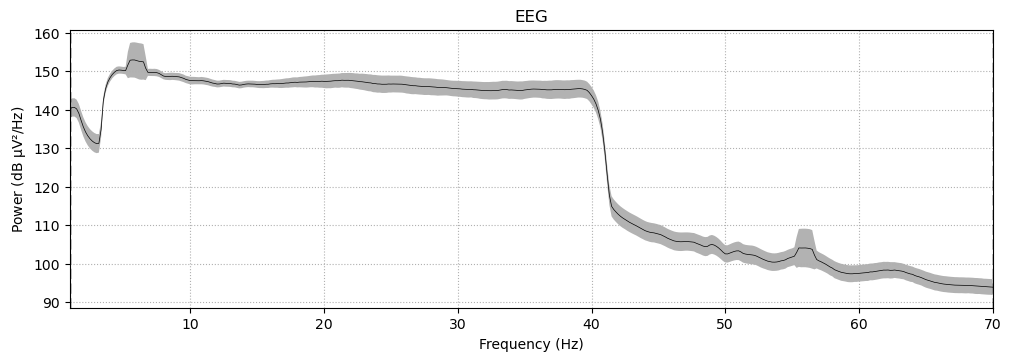

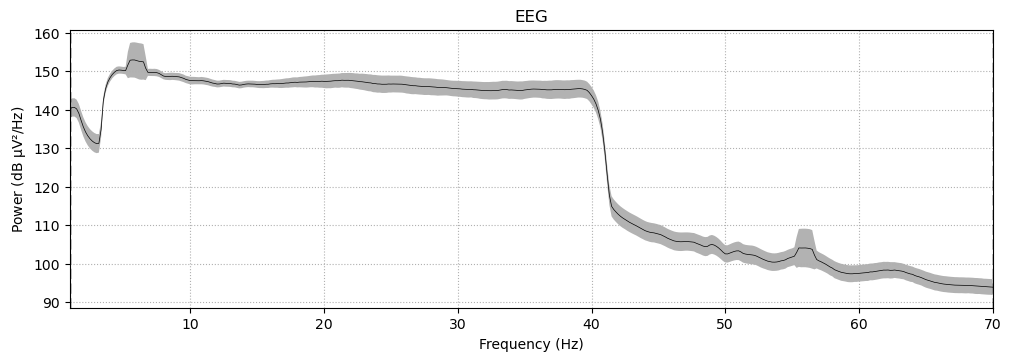

In [28]:
epochs._data = mne.filter.notch_filter(
    epochs.get_data(),
    Fs=epochs.info["sfreq"],
    freqs=50,          # or 60
    method="iir"
)


epochs.filter(
    l_freq=1,
    h_freq=70,
    method='iir'
)


epochs.compute_psd(fmin=1, fmax=70).plot(average=True, amplitude=False, picks="data", exclude="bads")

## 6. Remove bad channels and interpolate them

In [29]:
# Remove noisy channels

data = epochs.get_data(picks='eeg')  # shape: (n_epochs, n_ch, n_times)
variances = np.var(data, axis=(0, 2))

z = (variances - np.mean(variances)) / np.std(variances)

bad_idx = np.where(np.abs(z) > 5)[0]
bad_chs=[epochs.ch_names[i] for i in bad_idx]
print(bad_chs)

epochs.info['bads'].extend(bad_chs)
epochs.interpolate_bads(reset_bads=True)



[]
Setting channel interpolation method to {'eeg': 'spline'}.


/var/folders/dc/h57683ts1p9901rkn9pm87zr0000gn/T/ipykernel_88439/195670126.py:13: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


<EpochsArray | 434 events (all good), 0 – 5.996 s (baseline off), ~81.4 MB, data loaded,
 'left_hand': 222
 'right_hand': 212>

## 7. Rereference Signal

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


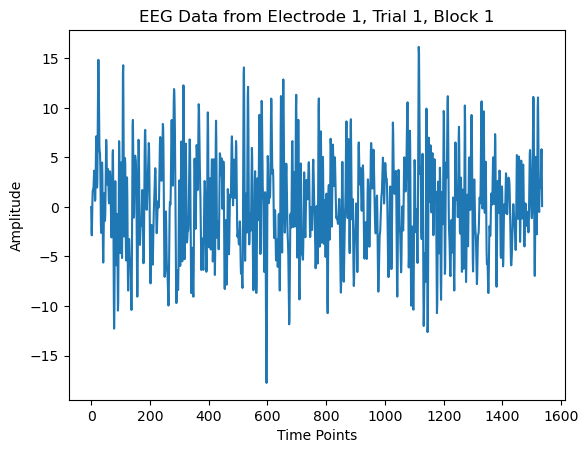

In [30]:
epochs.set_eeg_reference('average', projection=False)

eeg_data=epochs.get_data(picks='eeg')

plt.plot(eeg_data[0,0, :])
plt.title('EEG Data from Electrode 1, Trial 1, Block 1')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.show()


## 8. Remove artifacts with ICA

In [ ]:
ica = mne.preprocessing.ICA(
    n_components=0.9,
    random_state=42,
    method='infomax',
    fit_params=dict(extended=True),
    verbose=True
)
ica.fit(epochs)  
ica_labels = label_components(epochs, ica, method="iclabel")

ica.exclude =[
    i for i, label in enumerate(ica_labels['labels'])
    if label != 'brain'
]

cleaned_epochs = ica.apply(epochs.copy())


eeg_data=epochs.get_data(picks='eeg')

plt.plot(eeg_data[0,0, :])
plt.title('EEG Data from Electrode 1, Trial 1, Block 1')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.show()




Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by explained variance: 6 components
Computing Infomax ICA
Fitting ICA took 16.4s.


/var/folders/dc/h57683ts1p9901rkn9pm87zr0000gn/T/ipykernel_58114/1573036345.py:3: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(epochs, ica, method="iclabel")
/var/folders/dc/h57683ts1p9901rkn9pm87zr0000gn/T/ipykernel_58114/1573036345.py:3: RuntimeWarning: The provided ICA instance was fitted with a 'infomax' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ica_labels = label_components(epochs, ica, method="iclabel")
